# Импорт

* Разбиение данных по установкам
М1 - привели к отказу, М3 -нет
горизонт рула от 3 часов до месяца

In [1]:
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import QuantileTransformer
from tqdm import tqdm
import seaborn as sns


import os, sys
project_path = os.path.abspath('../../')
project_path = os.path.abspath('../')

if project_path not in sys.path:
    sys.path.append(project_path)

# from utils.plot_utils import fast_hist, fast_plot, fast_bar, fast_legend, fast_scatter, Pairs_plot

# pd.set_option('display.max_colwidth', None)


import sys
sys.path.insert(1, 'C:/Users/kompn/YandexDisk/tsad/')
from tsad.useful.ts import split_by_repeated
from tsad.eda.samplingRate import value_counts_interval
from IPython.display import display, HTML



# Загрузка данных

In [3]:
X_train = pd.read_parquet(f'{project_path}/data/raw/X_train.parquet')
X_test = pd.read_parquet(f'{project_path}/data/raw/X_test.parquet')

X_train.columns = [x.replace('ТОК РОТОРА2', 'ТОК РОТОРА 2') for x in X_train.columns]
X_test.columns = [x.replace('ТОК РОТОРА2', 'ТОК РОТОРА 2') for x in X_test.columns]

In [4]:
y_train = pd.read_parquet(f'{project_path}/data/raw/y_train.parquet').astype(np.int8)

In [5]:
path = f'{project_path}/data/processed/toir_train.parquet'
toir =  pd.read_parquet(path) 

In [6]:
toir = pd.read_excel('../data/messages.xlsx',index_col=0)

toir['num'] = toir['ИМЯ_МАШИНЫ'].apply(lambda x: int(x.split('№')[-1]))
toir['label'] = toir['ВИД_СООБЩЕНИЯ'].apply(lambda x: int(x[-1].replace('3','2')))
toir.drop(columns=['ИМЯ_МАШИНЫ','ВИД_СООБЩЕНИЯ'], inplace=True)
toir = toir.rename(columns={'ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ':'t1','ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ':'t2'})
toir = toir.iloc[3:]

In [7]:
mytoir = pd.read_excel('../data/processed/Processed_toir2.xlsx').set_index('Номер')['Причина']
t_test = pd.Timestamp('2020-09-27 16:42:02')

# Подготовка выборки для обучения

In [8]:
dt1 = pd.Timedelta('14D')
dt2 = pd.Timedelta('2h')
th_current_volt = 50

Xy = []

for num in nums:
    eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}. ' in x]].copy()[:t_test]
    eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
    
    eks = eks.fillna(method='pad',limit=60)
    eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
              (eks['ТОК РОТОРА 2']>50) |\
              (eks['ТОК СТАТОРА']>50)]     
    eks['y'] = 'Нормально'
    mini_toir = toir[toir['num']==num]
    idx  = toir.index[toir.index.isin(mytoir.index)]
    for nomer_zap in idx:
        t1 = toir['t1'][nomer_zap] - dt1
        t2 = toir['t1'][nomer_zap] - dt2
        eks['y'][t1:t2] = mytoir[nomer_zap]
    Xy.append(eks.copy().dropna())
Xy = pd.concat(Xy)                                          

X = Xy.copy()
y = X.pop('y')

C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eks['y'][t1:t2] = mytoir[nomer_zap]
C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

# Обучение 

In [11]:
from sklearn.neighbors import KNeighborsClassifier
cl = KNeighborsClassifier(n_neighbors=7,
                          n_jobs=-1,
                          metric='mahalanobis',
                          metric_params={'VI': np.cov(X, rowvar= False)},
                         )
cl.fit(X,y)



KNeighborsClassifier(metric='mahalanobis',
                     metric_params={'VI': array([[ 4.07703632e+03,  4.07703613e+03, -6.29358252e+02,
        -2.46533746e+02, -1.38695229e+01, -1.54411201e+01,
         7.07224594e+00, -6.06370756e+00,  6.10858727e+01,
         3.50824729e+01,  2.66009212e+01,  5.04021145e+00,
         2.71469152e+00, -9.02889669e+00,  3.53737584e+00,
         8.76221816e+00],
       [ 4.07703613e+03,  4.07705549e+03, -6...
         2.56962108e-01,  5.25129668e-01,  3.67727865e-01,
         1.27703261e+00,  1.29954992e+00,  1.74593721e+00,
         1.15961263e+00],
       [ 8.76221816e+00,  8.76225154e+00, -1.51165151e+02,
         2.90087128e-01,  9.89259052e-01,  9.58363858e-01,
         2.05326041e-01,  3.17475521e-01,  2.85222496e-01,
        -8.67327555e-01,  4.53132963e-01,  4.04765629e-01,
         9.82126591e-01,  1.14154498e+00,  1.15961263e+00,
         1.41945894e+00]])},
                     n_jobs=-1, n_neighbors=7)

# Валидаиция

In [53]:
for nomer_zap in mytoir.index:
    if toir['t1'][nomer_zap] < t_test:
        continue
    else:
        num = toir.loc[nomer_zap]['num']
        t1 = toir['t1'][nomer_zap] - pd.Timedelta('1D')
        t2 = toir['t1'][nomer_zap]
        
        eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}. ' in x]][t1:t2]
        eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
        eks = eks.fillna(method='pad',limit=60)
        eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
                  (eks['ТОК РОТОРА 2']>50) |\
                  (eks['ТОК СТАТОРА']>50)]  
        eks = eks.dropna()

        print(mytoir.loc[nomer_zap])
#         predict = cl.predict(eks[::100])
#         display(pd.Series(predict).value_counts())
        
        predict = cl.kneighbors(eks[::60],return_distance=False)
        predict = pd.DataFrame(predict).apply(lambda x: y.values[x])  
        preditc_new = predict.iloc[:,0].copy()
        predict = pd.concat( [predict.iloc[:,i] == predict.iloc[:,0] for i in range(predict.shape[1])],axis=1).all(axis=1)
        preditc_new[~predict] = 'Сомневаюсь'
        display(pd.Series(preditc_new).value_counts())
        
        print()
        print()
        print()
        
        

C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель


Сомневаюсь         96
ЭлектроТиристор    30
Нормально          13
РоторМеханика       3
Name: 0, dtype: int64




ДвигательТемп


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ДвигательТемп    119
Нормально          6
Сомневаюсь         1
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Сомневаюсь          40
ЭлектроДвигатель    20
РоторМеханика       12
Нормально            8
ЭлектроТиристор      3
ДвигательТемп        1
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    53
Сомневаюсь          40
Нормально            6
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    54
Сомневаюсь          37
Нормально            3
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    40
Сомневаюсь          13
Нормально            9
РоторВибр            3
РоторМеханика        1
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально     81
Сомневаюсь    26
Масло         17
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           53
Сомневаюсь          30
ЭлектроДвигатель    17
РоторМеханика        2
РоторВибр            1
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           97
ЭлектроДвигатель    26
Сомневаюсь          10
Масло                1
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    112
Сомневаюсь           18
Нормально             9
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Сомневаюсь          74
Нормально           54
ЭлектроДвигатель     8
Масло                4
Name: 0, dtype: int64




Задвижка


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально        92
Сомневаюсь       51
ДвигательТемп     1
Name: 0, dtype: int64




Задвижка


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    81
Сомневаюсь          36
Масло               21
Нормально            3
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально        101
Сомневаюсь        24
РоторМеханика     16
РоторВибр          1
Name: 0, dtype: int64




РоторВибр


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


РоторМеханика       82
Сомневаюсь          53
Нормально            5
ЭлектроДвигатель     1
Name: 0, dtype: int64




Масло


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           125
Сомневаюсь           14
ЭлектроДвигатель      1
Name: 0, dtype: int64




Масло


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    78
Сомневаюсь          42
Нормально           12
Name: 0, dtype: int64




Масло


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           123
Сомневаюсь           17
ЭлектроДвигатель      1
Name: 0, dtype: int64




РоторВибр


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    61
Сомневаюсь          48
Нормально           32
Масло                2
РоторВибр            1
Name: 0, dtype: int64




РоторВибр


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Сомневаюсь       107
Масло             25
ДвигательТемп      6
РоторМеханика      5
Name: 0, dtype: int64

C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Масло


ДвигательТемп    142
Сомневаюсь         2
Name: 0, dtype: int64

# Инференс. Подготовка submission_1.xlsx

In [77]:
y_test = pd.read_excel('../data/test_intervals.xlsx').set_index('Unnamed: 0')#.rename(columns={'start':'t1'})
y_test.head(1)

,start,finish,machine,tm
Unnamed: 0,,,,
97,2022-01-01 10:54:53,2022-01-01 16:43:39,NaN,NaN


In [ ]:
dt1_new = pd.Timedelta('10D')

for nomer_zap in y_test.index:
    print('================================================')
    print('Номер записи',nomer_zap)
    t = y_test['start'].loc[nomer_zap]
    
    t1 = t - dt1_new
    t2 = t
    
    all_eks_result_predict = pd.DataFrame(columns=['num','percent','fualt'])
    for num in nums:
        print(f'ЭКС №{num}')
        if num==8:
            continue
        
        eks = X_test[[x for x in X_test.columns if f'ЭКСГАУСТЕР {num}. ' in x]][t1:t2]
        eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','', regex=False)
        eks = eks.fillna(method='pad',limit=60)
        eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
                  (eks['ТОК РОТОРА 2']>50) |\
                  (eks['ТОК СТАТОРА']>50)]  
        eks = eks.dropna()
        if len(eks)==0:
            print('Нет данных ')
            continue
        
        t1 = eks.index[-1] - pd.Timedelta('1D')
        eks = eks[t1:t2]
        

        predict = cl.kneighbors(eks[::60],return_distance=False)
        predict = pd.DataFrame(predict).apply(lambda x: y.values[x])  
        preditc_new = predict.iloc[:,0].copy()
        predict = pd.concat( [predict.iloc[:,i] == predict.iloc[:,0] for i in range(predict.shape[1])],axis=1).all(axis=1)
        preditc_new[~predict] = 'Сомневаюсь'
        predict = pd.Series(preditc_new).value_counts()
        display(predict)
        
        all_eks_result_predict.loc[len(all_eks_result_predict)] = [num,
                                                                   predict.values[0]/predict.sum()*100,
                                                                   predict.index[0]]

    display(all_eks_result_predict)
    all_eks_result_predict = all_eks_result_predict[all_eks_result_predict['fualt']!='Сомневаюсь']
    all_eks_result_predict = all_eks_result_predict[all_eks_result_predict['fualt']!='Нормально']
    if len(all_eks_result_predict)>0:
        res_fot_zap = all_eks_result_predict.sort_values(by='percent',ascending=False).iloc[0]
        display(res_fot_zap)
        y_test.loc[nomer_zap,'machine'] = 'ЭКСГАУСТЕР А/М №' + str(res_fot_zap['num'])
        
        minimin_toir = toir.loc[mytoir[mytoir ==  res_fot_zap['fualt']].index]
        if len(minimin_toir[minimin_toir['num']==res_fot_zap['num']])==0:
            y_test.loc[nomer_zap,'tm'] =  minimin_toir['НАЗВАНИЕ_ТЕХ_МЕСТА'].values[0]
        else:
            y_test.loc[nomer_zap,'tm'] =  minimin_toir[minimin_toir['num']==res_fot_zap['num']]\
            ['НАЗВАНИЕ_ТЕХ_МЕСТА'].values[0]
        y_test.to_excel('submission_1.xlsx')

    else:
        pass        
    print('================================================')
    print()

Номер записи 97
ЭКС №4


Сомневаюсь       51
РоторМеханика     9
Нормально         3
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          51
ЭлектроДвигатель    10
Масло                4
Нормально            1
Name: 0, dtype: int64

ЭКС №6


РоторМеханика    55
Сомневаюсь        7
Name: 0, dtype: int64

ЭКС №7


Нормально     64
Сомневаюсь     2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Нормально          27
Сомневаюсь         24
ЭлектроТиристор    14
РоторМеханика       1
Name: 0, dtype: int64

,num,percent,fualt
0,4,80.952381,Сомневаюсь
1,5,77.272727,Сомневаюсь
2,6,88.709677,РоторМеханика
3,7,96.969697,Нормально
4,9,40.909091,Нормально


num                    6
percent        88.709677
fualt      РоторМеханика
Name: 2, dtype: object


Номер записи 118
ЭКС №4


Сомневаюсь       105
РоторМеханика      5
Нормально          1
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          56
Нормально           30
ЭлектроДвигатель    19
Масло               10
РоторВибр            1
Name: 0, dtype: int64

ЭКС №6


РоторМеханика    86
Сомневаюсь       25
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          59
Нормально           34
РоторМеханика       11
РоторВибр            9
ЭлектроДвигатель     6
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          66
Нормально           46
ЭлектроТиристор      3
ЭлектроДвигатель     2
РоторМеханика        2
Name: 0, dtype: int64

,num,percent,fualt
0,4,94.594595,Сомневаюсь
1,5,48.275862,Сомневаюсь
2,6,77.477477,РоторМеханика
3,7,49.579832,Сомневаюсь
4,9,55.462185,Сомневаюсь


num                    6
percent        77.477477
fualt      РоторМеханика
Name: 2, dtype: object


Номер записи 126
ЭКС №4


Сомневаюсь       98
Нормально        35
РоторМеханика     4
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          71
Нормально           49
Масло               23
ЭлектроДвигатель     1
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          70
ЭлектроДвигатель    66
Нормально            2
ЭлектроТиристор      1
РоторМеханика        1
Name: 0, dtype: int64

ЭКС №7


Нормально           101
Сомневаюсь           27
ЭлектроДвигатель     15
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          66
Нормально           16
РоторМеханика       12
ЭлектроТиристор      8
РоторВибр            5
ДвигательТемп        1
ЭлектроДвигатель     1
Name: 0, dtype: int64

,num,percent,fualt
0,4,71.532847,Сомневаюсь
1,5,49.305556,Сомневаюсь
2,6,50.000000,Сомневаюсь
3,7,70.629371,Нормально
4,9,60.550459,Сомневаюсь



Номер записи 163
ЭКС №4


Сомневаюсь       93
Нормально        23
РоторМеханика     5
Name: 0, dtype: int64

ЭКС №5


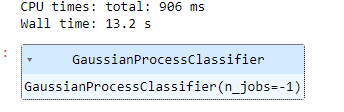